In [7]:
# MSIT 3103 — Environment setup (run this cell once per machine)
# Installs/updates the required packages into the same Python used by this notebook

import sys
print(f"Using Python {sys.version.split()[0]}")

# Install required packages into the current notebook environment
%pip install -qU numpy matplotlib scikit-learn

# Verify versions
import numpy as np, matplotlib, sklearn
print("numpy       :", np.__version__)
print("matplotlib  :", matplotlib.__version__)
print("scikit-learn:", sklearn.__version__)
print("✅ Setup complete!")


Using Python 3.13.5
Note: you may need to restart the kernel to use updated packages.
numpy       : 2.3.2
matplotlib  : 3.10.6
scikit-learn: 1.7.1
✅ Setup complete!


In [8]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.datasets import load_digits
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import StratifiedKFold, cross_val_score
from sklearn.pipeline import make_pipeline
from sklearn.svm import SVC
from sklearn.utils import Bunch
import time
from cifar10_loader import load_cifar10
train = load_cifar10('cifar-10-batches-py', subset='train', normalize=True, flatten=True)
test  = load_cifar10('cifar-10-batches-py', subset='test',  normalize=True, flatten=True)
# number of training samples to use
n=5000
# number of test samples to use
nt=1000
# number of iterations
iterations=100


# Comparing different penalties with different C values accross a subset of the Cifar-10 dataset

Logistic regression test accuracy: 0.3390
              precision    recall  f1-score   support

           0       0.40      0.36      0.38       103
           1       0.46      0.46      0.46        89
           2       0.27      0.26      0.27       100
           3       0.20      0.19      0.20       103
           4       0.24      0.27      0.25        90
           5       0.19      0.19      0.19        86
           6       0.42      0.40      0.41       112
           7       0.40      0.39      0.40       102
           8       0.39      0.52      0.44       106
           9       0.40      0.32      0.36       109

    accuracy                           0.34      1000
   macro avg       0.34      0.34      0.33      1000
weighted avg       0.34      0.34      0.34      1000



/Users/rkutyna/CascadeProjects/MSIT3103/MSIT3103-GenAI-assignments/.venv/lib/python3.13/site-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


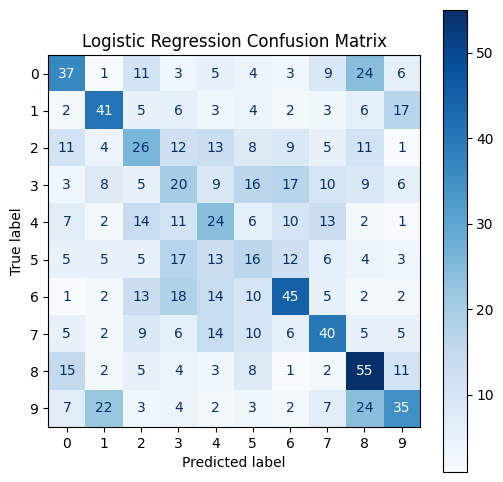

In [9]:
# Logistic regression model creation - using solver saga and penalty l2
lr_model = LogisticRegression(solver='saga', max_iter=iterations, penalty='l2', verbose=0, n_jobs=-1)
lr_model.fit(train.data[:n], train.target[:n])

# Evaluate on the test set
test_predictions = lr_model.predict(test.data[:nt])
accuracy = (test.target[:nt] == test_predictions).mean()

print(f'Logistic regression test accuracy: {accuracy:.4f}')

# Classification report
print(classification_report(test.target[:nt], test_predictions))

# Confusion matrix
cm = confusion_matrix(test.target[:nt], test_predictions)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=lr_model.classes_)
fig, ax = plt.subplots(figsize=(6, 6))
disp.plot(ax=ax, cmap='Blues')
plt.title('Logistic Regression Confusion Matrix')
plt.show()

In [13]:
# Code generated by GPT-5(high reasoning) via Windsurf 9/4/25 then modified by Roger Kutyna
# Prompt: "@assignment1.ipynb#X12sZmlsZQ%3D%3D#L1-49 I am trying to adapt this code to work 
# with a new data set with different workings and variables, can you fix this function to 
# work with this data? If you need to change the number of training or test samples, you are 
# welcome to, just please keep it below 5000 for each because otherwise it takes too long. 
# Here is the new data @assignment1.ipynb#W1sZmlsZQ%3D%3D#L11-19 . It is in the form of 
# sklearn bunches. I am using this to test different penalties accross different C values, 
# so this will be run in a for loop with different penalites passed to it. That is why I set 
# the solver to "saga", because it will work with all penalties and remain consistent"

import warnings
from sklearn.exceptions import ConvergenceWarning
warnings.filterwarnings("ignore", category=ConvergenceWarning)

def test_multiple_C(
    penalty: str,
    iters: int,
    train_bunch,
    test_bunch=None,
    n: int = 5000,
    nt: int = 1000,
    l1_ratio: float = 0.5,
    random_state: int = 42,
):
    """
    Evaluate LogisticRegression(solver='saga') across a range of C values
    on a subset of the provided sklearn Bunches (train/test).

    Parameters
    - penalty: one of {'l1','l2','elasticnet','none'}
    - iters: max_iter for LogisticRegression
    - train_bunch: sklearn Bunch with .data and .target
    - test_bunch: optional sklearn Bunch for final test evaluation
    - n: number of training samples to use (<= 5000 recommended)
    - nt: number of test samples to use (<= 5000 recommended)
    - l1_ratio: only used when penalty == 'elasticnet'
    - random_state: for reproducibility

    Returns: dict with arrays and the fitted best estimator
    """

    # Respect dataset bounds
    n = min(n, train_bunch.data.shape[0])
    if test_bunch is not None:
        nt = min(nt, test_bunch.data.shape[0])

    X_train = train_bunch.data[:n]
    y_train = train_bunch.target[:n]

    # Sweep C on a log scale
    Cs = np.logspace(-3, 3, 9)

    cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=random_state)
    val_means, val_stds, train_scores = [], [], []

    for C in Cs:
        print("C:", C)
        # Build LR kwargs, adding l1_ratio only for elasticnet
        lr_kwargs = dict(
            C=C,
            penalty=penalty,
            solver="saga",
            max_iter=iters,
            random_state=random_state,
            tol=0.001
        )
        if penalty == "elasticnet":
            lr_kwargs["l1_ratio"] = l1_ratio

        est = make_pipeline(
            StandardScaler(),
            LogisticRegression(**lr_kwargs)
        )

        # Cross-validated accuracy on the training subset
        cv_scores = cross_val_score(
            est, X_train, y_train, cv=cv, scoring="accuracy", n_jobs=-1
        )
        val_means.append(cv_scores.mean())
        val_stds.append(cv_scores.std())

        # Training accuracy (fit on entire subset, score on same subset)
        est.fit(X_train, y_train)
        train_scores.append(est.score(X_train, y_train))

    # Print compact table
    print("C\t\tTrainAcc\tCV Acc (mean ± std)")
    for C, tr, m, s in zip(Cs, train_scores, val_means, val_stds):
        print(f"{C:>7.4f}\t{tr:.4f}\t\t{m:.4f} ± {s:.4f}")

    best_idx = int(np.argmax(val_means))
    best_C = Cs[best_idx]
    print(f"\nBest C by CV mean: {best_C:.4f} (CV={val_means[best_idx]:.4f} ± {val_stds[best_idx]:.4f})")

    # Fit best model on the training subset and optionally evaluate on test subset
    best_lr_kwargs = dict(
        C=best_C,
        penalty=penalty,
        solver="saga",
        max_iter=iters,
        random_state=random_state,
    )
    if penalty == "elasticnet":
        best_lr_kwargs["l1_ratio"] = l1_ratio

    best_est = make_pipeline(StandardScaler(), LogisticRegression(**best_lr_kwargs))
    best_est.fit(X_train, y_train)

    test_acc = None
    if test_bunch is not None:
        X_test = test_bunch.data[:nt]
        y_test = test_bunch.target[:nt]
        test_acc = best_est.score(X_test, y_test)
        print(f"Test accuracy with best C on {nt} samples: {test_acc:.4f}")

    # Plot
    plt.figure(figsize=(7, 4))
    plt.semilogx(Cs, train_scores, marker="o", label="Train accuracy", alpha=0.7)
    plt.semilogx(Cs, val_means, marker="o", label="CV accuracy (mean)", alpha=0.9)
    plt.fill_between(
        Cs,
        np.array(val_means) - np.array(val_stds),
        np.array(val_means) + np.array(val_stds),
        color="C1",
        alpha=0.2,
        label="CV ± 1 std",
    )
    plt.xlabel("C (inverse regularization)")
    plt.ylabel("Accuracy")
    plt.title(f"Validation curve for Logistic Regression (penalty={penalty})")
    plt.legend()
    plt.tight_layout()
    plt.show()

    return {
        "Cs": Cs,
        "cv_mean": np.array(val_means),
        "cv_std": np.array(val_stds),
        "train_acc": np.array(train_scores),
        "best_C": best_C,
        "best_estimator": best_est,
        "test_acc": test_acc,
    }

l1
C: 0.001
C: 0.005623413251903491
C: 0.03162277660168379
C: 0.1778279410038923
C: 1.0
C: 5.623413251903491
C: 31.622776601683793
C: 177.82794100389228
C: 1000.0
C		TrainAcc	CV Acc (mean ± std)
 0.0010	0.1120		0.1080 ± 0.0040
 0.0056	0.1120		0.1090 ± 0.0037
 0.0316	0.3440		0.2660 ± 0.0258
 0.1778	0.7000		0.3490 ± 0.0285
 1.0000	0.9420		0.3290 ± 0.0267
 5.6234	0.9790		0.3130 ± 0.0223
31.6228	0.9800		0.3100 ± 0.0241
177.8279	0.9810		0.3100 ± 0.0241
1000.0000	0.9810		0.3100 ± 0.0241

Best C by CV mean: 0.1778 (CV=0.3490 ± 0.0285)
Test accuracy with best C on 5000 samples: 0.3182


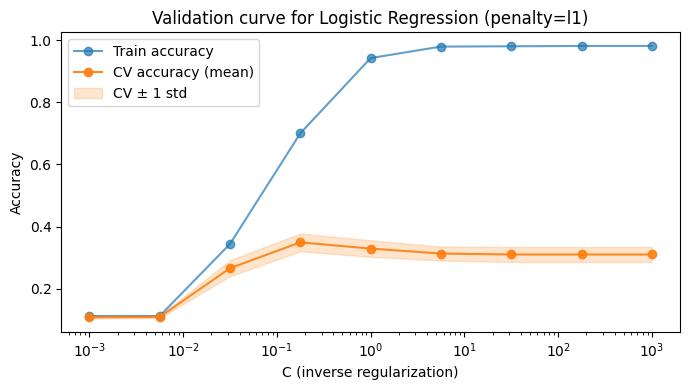

l2
C: 0.001
C: 0.005623413251903491
C: 0.03162277660168379
C: 0.1778279410038923
C: 1.0
C: 5.623413251903491
C: 31.622776601683793
C: 177.82794100389228
C: 1000.0
C		TrainAcc	CV Acc (mean ± std)
 0.0010	0.6450		0.3490 ± 0.0400
 0.0056	0.8490		0.3390 ± 0.0337
 0.0316	0.9640		0.3120 ± 0.0220
 0.1778	0.9800		0.3110 ± 0.0244
 1.0000	0.9800		0.3090 ± 0.0252
 5.6234	0.9810		0.3100 ± 0.0241
31.6228	0.9810		0.3100 ± 0.0241
177.8279	0.9810		0.3100 ± 0.0241
1000.0000	0.9810		0.3100 ± 0.0241

Best C by CV mean: 0.0010 (CV=0.3490 ± 0.0400)
Test accuracy with best C on 5000 samples: 0.3332


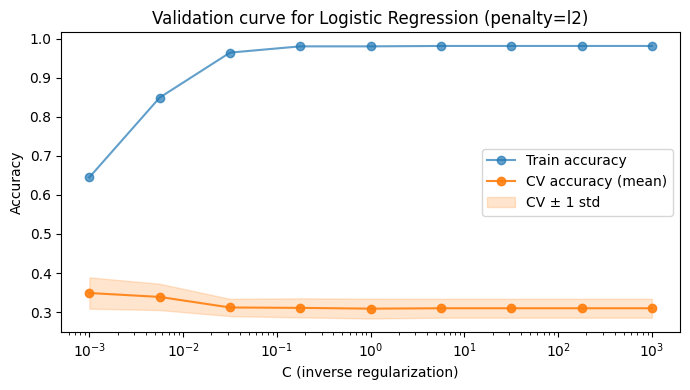

elasticnet
C: 0.001
C: 0.005623413251903491
C: 0.03162277660168379
C: 0.1778279410038923
C: 1.0
C: 5.623413251903491
C: 31.622776601683793
C: 177.82794100389228
C: 1000.0
C		TrainAcc	CV Acc (mean ± std)
 0.0010	0.1120		0.1090 ± 0.0037
 0.0056	0.1120		0.1090 ± 0.0037
 0.0316	0.4720		0.3260 ± 0.0500
 0.1778	0.8220		0.3360 ± 0.0302
 1.0000	0.9660		0.3180 ± 0.0216
 5.6234	0.9800		0.3110 ± 0.0231
31.6228	0.9800		0.3100 ± 0.0241
177.8279	0.9810		0.3100 ± 0.0241
1000.0000	0.9810		0.3100 ± 0.0241

Best C by CV mean: 0.1778 (CV=0.3360 ± 0.0302)
Test accuracy with best C on 5000 samples: 0.3122


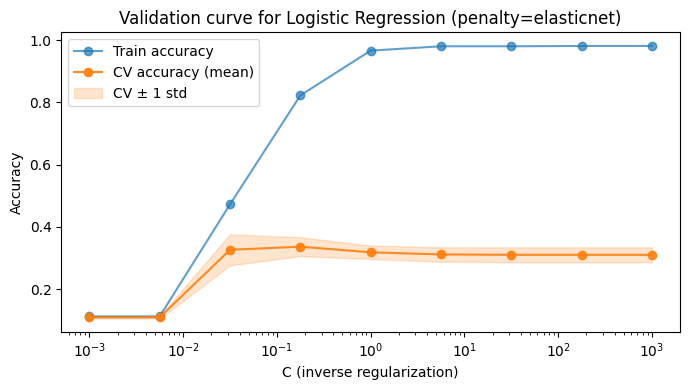

None
C: 0.001


/Users/rkutyna/CascadeProjects/MSIT3103/MSIT3103-GenAI-assignments/.venv/lib/python3.13/site-packages/sklearn/linear_model/_logistic.py:1232: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
/Users/rkutyna/CascadeProjects/MSIT3103/MSIT3103-GenAI-assignments/.venv/lib/python3.13/site-packages/sklearn/linear_model/_logistic.py:1232: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
/Users/rkutyna/CascadeProjects/MSIT3103/MSIT3103-GenAI-assignments/.venv/lib/python3.13/site-packages/sklearn/linear_model/_logistic.py:1232: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
/Users/rkutyna/CascadeProjects/MSIT3103/MSIT3103-GenAI-assignments/.venv/lib/python3.13/site-packages/sklearn/linear_model/_logistic.py:1232: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
/Users/rkutyna/CascadeProjects/MSIT3103/MSIT3103-GenAI-assig

C: 0.005623413251903491


/Users/rkutyna/CascadeProjects/MSIT3103/MSIT3103-GenAI-assignments/.venv/lib/python3.13/site-packages/sklearn/linear_model/_logistic.py:1232: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
/Users/rkutyna/CascadeProjects/MSIT3103/MSIT3103-GenAI-assignments/.venv/lib/python3.13/site-packages/sklearn/linear_model/_logistic.py:1232: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
/Users/rkutyna/CascadeProjects/MSIT3103/MSIT3103-GenAI-assignments/.venv/lib/python3.13/site-packages/sklearn/linear_model/_logistic.py:1232: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
/Users/rkutyna/CascadeProjects/MSIT3103/MSIT3103-GenAI-assignments/.venv/lib/python3.13/site-packages/sklearn/linear_model/_logistic.py:1232: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
/Users/rkutyna/CascadeProjects/MSIT3103/MSIT3103-GenAI-assig

C: 0.03162277660168379


/Users/rkutyna/CascadeProjects/MSIT3103/MSIT3103-GenAI-assignments/.venv/lib/python3.13/site-packages/sklearn/linear_model/_logistic.py:1232: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
/Users/rkutyna/CascadeProjects/MSIT3103/MSIT3103-GenAI-assignments/.venv/lib/python3.13/site-packages/sklearn/linear_model/_logistic.py:1232: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
/Users/rkutyna/CascadeProjects/MSIT3103/MSIT3103-GenAI-assignments/.venv/lib/python3.13/site-packages/sklearn/linear_model/_logistic.py:1232: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
/Users/rkutyna/CascadeProjects/MSIT3103/MSIT3103-GenAI-assignments/.venv/lib/python3.13/site-packages/sklearn/linear_model/_logistic.py:1232: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
/Users/rkutyna/CascadeProjects/MSIT3103/MSIT3103-GenAI-assig

C: 0.1778279410038923


/Users/rkutyna/CascadeProjects/MSIT3103/MSIT3103-GenAI-assignments/.venv/lib/python3.13/site-packages/sklearn/linear_model/_logistic.py:1232: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
/Users/rkutyna/CascadeProjects/MSIT3103/MSIT3103-GenAI-assignments/.venv/lib/python3.13/site-packages/sklearn/linear_model/_logistic.py:1232: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
/Users/rkutyna/CascadeProjects/MSIT3103/MSIT3103-GenAI-assignments/.venv/lib/python3.13/site-packages/sklearn/linear_model/_logistic.py:1232: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
/Users/rkutyna/CascadeProjects/MSIT3103/MSIT3103-GenAI-assignments/.venv/lib/python3.13/site-packages/sklearn/linear_model/_logistic.py:1232: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
/Users/rkutyna/CascadeProjects/MSIT3103/MSIT3103-GenAI-assig

C: 1.0
C: 5.623413251903491


/Users/rkutyna/CascadeProjects/MSIT3103/MSIT3103-GenAI-assignments/.venv/lib/python3.13/site-packages/sklearn/linear_model/_logistic.py:1232: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
/Users/rkutyna/CascadeProjects/MSIT3103/MSIT3103-GenAI-assignments/.venv/lib/python3.13/site-packages/sklearn/linear_model/_logistic.py:1232: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
/Users/rkutyna/CascadeProjects/MSIT3103/MSIT3103-GenAI-assignments/.venv/lib/python3.13/site-packages/sklearn/linear_model/_logistic.py:1232: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
/Users/rkutyna/CascadeProjects/MSIT3103/MSIT3103-GenAI-assignments/.venv/lib/python3.13/site-packages/sklearn/linear_model/_logistic.py:1232: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
/Users/rkutyna/CascadeProjects/MSIT3103/MSIT3103-GenAI-assig

C: 31.622776601683793


/Users/rkutyna/CascadeProjects/MSIT3103/MSIT3103-GenAI-assignments/.venv/lib/python3.13/site-packages/sklearn/linear_model/_logistic.py:1232: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
/Users/rkutyna/CascadeProjects/MSIT3103/MSIT3103-GenAI-assignments/.venv/lib/python3.13/site-packages/sklearn/linear_model/_logistic.py:1232: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
/Users/rkutyna/CascadeProjects/MSIT3103/MSIT3103-GenAI-assignments/.venv/lib/python3.13/site-packages/sklearn/linear_model/_logistic.py:1232: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
/Users/rkutyna/CascadeProjects/MSIT3103/MSIT3103-GenAI-assignments/.venv/lib/python3.13/site-packages/sklearn/linear_model/_logistic.py:1232: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
/Users/rkutyna/CascadeProjects/MSIT3103/MSIT3103-GenAI-assig

C: 177.82794100389228


/Users/rkutyna/CascadeProjects/MSIT3103/MSIT3103-GenAI-assignments/.venv/lib/python3.13/site-packages/sklearn/linear_model/_logistic.py:1232: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
/Users/rkutyna/CascadeProjects/MSIT3103/MSIT3103-GenAI-assignments/.venv/lib/python3.13/site-packages/sklearn/linear_model/_logistic.py:1232: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
/Users/rkutyna/CascadeProjects/MSIT3103/MSIT3103-GenAI-assignments/.venv/lib/python3.13/site-packages/sklearn/linear_model/_logistic.py:1232: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
/Users/rkutyna/CascadeProjects/MSIT3103/MSIT3103-GenAI-assignments/.venv/lib/python3.13/site-packages/sklearn/linear_model/_logistic.py:1232: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
/Users/rkutyna/CascadeProjects/MSIT3103/MSIT3103-GenAI-assig

C: 1000.0


/Users/rkutyna/CascadeProjects/MSIT3103/MSIT3103-GenAI-assignments/.venv/lib/python3.13/site-packages/sklearn/linear_model/_logistic.py:1232: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
/Users/rkutyna/CascadeProjects/MSIT3103/MSIT3103-GenAI-assignments/.venv/lib/python3.13/site-packages/sklearn/linear_model/_logistic.py:1232: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
/Users/rkutyna/CascadeProjects/MSIT3103/MSIT3103-GenAI-assignments/.venv/lib/python3.13/site-packages/sklearn/linear_model/_logistic.py:1232: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
/Users/rkutyna/CascadeProjects/MSIT3103/MSIT3103-GenAI-assignments/.venv/lib/python3.13/site-packages/sklearn/linear_model/_logistic.py:1232: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
/Users/rkutyna/CascadeProjects/MSIT3103/MSIT3103-GenAI-assig

C		TrainAcc	CV Acc (mean ± std)
 0.0010	0.9810		0.3100 ± 0.0241
 0.0056	0.9810		0.3100 ± 0.0241
 0.0316	0.9810		0.3100 ± 0.0241
 0.1778	0.9810		0.3100 ± 0.0241
 1.0000	0.9810		0.3100 ± 0.0241
 5.6234	0.9810		0.3100 ± 0.0241
31.6228	0.9810		0.3100 ± 0.0241
177.8279	0.9810		0.3100 ± 0.0241
1000.0000	0.9810		0.3100 ± 0.0241

Best C by CV mean: 0.0010 (CV=0.3100 ± 0.0241)


/Users/rkutyna/CascadeProjects/MSIT3103/MSIT3103-GenAI-assignments/.venv/lib/python3.13/site-packages/sklearn/linear_model/_logistic.py:1232: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(


Test accuracy with best C on 5000 samples: 0.2924


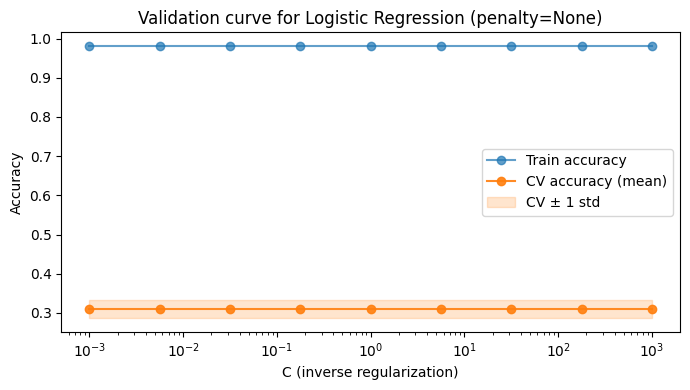

In [14]:
penalties=["l1", "l2", "elasticnet", None]
for p in penalties:
    print(p)
    test_multiple_C(penalty=p, iters=iterations, train_bunch=train, test_bunch=test, n=1000, nt=5000)

### Result
It appears that the l2 penalty was the most effective for this application with an accuracy of 0.3332, which beat l1 with 0.3182, None with 0.2924, and elasticnet with 0.3122. It did this with a c value of 0.001, the smallest one tested. As for why it performed the way it did, totally dropping off in performance at larger c values, I am not sure, but it didn't present a curve like l1 that increases before plateuing.

#### Testing SVM to compare to Logistic Regression

Logistic regression test accuracy: 0.4230
              precision    recall  f1-score   support

           0       0.46      0.45      0.45       103
           1       0.57      0.48      0.52        89
           2       0.32      0.32      0.32       100
           3       0.32      0.24      0.28       103
           4       0.23      0.28      0.25        90
           5       0.35      0.35      0.35        86
           6       0.43      0.47      0.45       112
           7       0.51      0.41      0.45       102
           8       0.54      0.66      0.60       106
           9       0.48      0.52      0.50       109

    accuracy                           0.42      1000
   macro avg       0.42      0.42      0.42      1000
weighted avg       0.42      0.42      0.42      1000



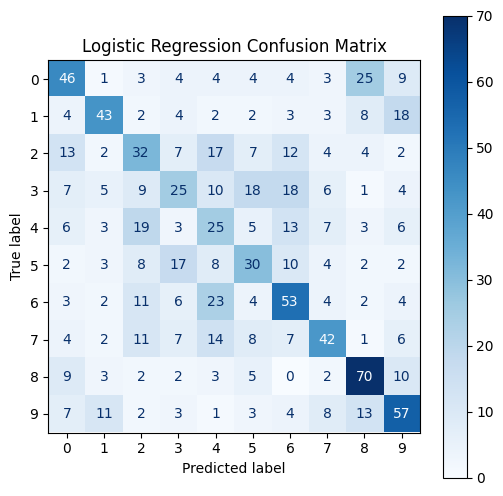

In [12]:
# Logistic regression model creation - using solver saga and penalty l2
svm_model = SVC(max_iter=10000)
svm_model.fit(train.data[:n], train.target[:n])

# Evaluate on the test set
test_predictions = svc_model.predict(test.data[:nt])
accuracy = (test.target[:nt] == test_predictions).mean()

print(f'Logistic regression test accuracy: {accuracy:.4f}')

# Classification report
print(classification_report(test.target[:nt], test_predictions))

# Confusion matrix
cm = confusion_matrix(test.target[:nt], test_predictions)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=svm_model.classes_)
fig, ax = plt.subplots(figsize=(6, 6))
disp.plot(ax=ax, cmap='Blues')
plt.title('Logistic Regression Confusion Matrix')
plt.show()

#### SVM vs Logistic Regression

Without much tuning at all, the SVM works substantially better than the logistic regression. The accuracy of the SVM is 0.42, while the accuracy of the logistic regressnion topped out around 0.35 using the penalty l2 and the C value of 0.001.

# GAN implementation

In [17]:
# Generated by GPT-5 (high reasoning) via Windsurf 9/4/25
# Prompt: "@assignment1.ipynb#X24sZmlsZQ%3D%3D#L1-260 Can 
# you modify this code to work with this data? It is the cifar-10 
# dataset in the form of sklearn bunches.@assignment1.ipynb#W1sZmlsZQ%3D%3D#L13-15 "
# The context in this prompt is the previous simple GAN function from the hotstart file
# Along with the cifar10_loader function

# simple_gan.py
# Updated GAN training utility compatible with CIFAR-10 Bunch objects or NumPy arrays
from __future__ import annotations

from typing import Any, Dict, List, Tuple, Union

import numpy as np
import matplotlib.pyplot as plt

try:
    from sklearn.utils import Bunch  # type: ignore
except Exception:  # sklearn might not be installed in all contexts
    Bunch = object  # fallback type to allow isinstance checks to pass


ArrayLike = np.ndarray


def _as_array_data(X_gan: Union[ArrayLike, Bunch]) -> ArrayLike:
    """
    Accepts either a scikit-learn Bunch (with a `.data` field) or a NumPy array and
    returns a 2D NumPy array of shape (N, D). If input is images (N, H, W, C),
    it will be flattened to (N, H*W*C).
    """
    # If Bunch-like with `.data`
    if hasattr(X_gan, "data"):
        X = getattr(X_gan, "data")
    else:
        X = X_gan

    X = np.asarray(X)

    # If images (N, H, W, C), flatten
    if X.ndim == 4:
        N, H, W, C = X.shape
        X = X.reshape(N, H * W * C)
    elif X.ndim != 2:
        raise ValueError(f"Expected 2D array (N, D) or 4D images (N, H, W, C), got shape {X.shape}")

    # Ensure float32 for numerical stability/perf
    if X.dtype != np.float32 and X.dtype != np.float64:
        X = X.astype(np.float32, copy=False)

    return X


def _scale_to_tanh_range(X: ArrayLike) -> ArrayLike:
    """
    Scale features to approximately match tanh output range [-1, 1].
    Heuristics:
    - If values in [0, 1], map with X*2-1.
    - Else if values look like 0..255, map with X/127.5-1.
    - Else if already in [-1, 1], leave as-is.
    - Else fallback to min-max scaling to [-1, 1].
    """
    X_min = np.min(X)
    X_max = np.max(X)

    if X_min >= -1.000001 and X_max <= 1.000001:
        return X.astype(np.float32, copy=False)

    if X_min >= -1e-6 and X_max <= 1.0 + 1e-6:
        return (X * 2.0 - 1.0).astype(np.float32, copy=False)

    if X_min >= -1e-6 and X_max > 1.0:
        # Likely 0..255 or similar
        return (X / 127.5 - 1.0).astype(np.float32, copy=False)

    # Fallback: min-max to [-1, 1]
    denom = max(X_max - X_min, 1e-8)
    X_scaled = (X - X_min) / denom
    X_scaled = X_scaled * 2.0 - 1.0
    return X_scaled.astype(np.float32, copy=False)


def train_simple_gan(
    X_gan: Union[ArrayLike, Bunch],
    noise_dim: int = 20,
    hidden_dim_g: int = 64,
    hidden_dim_d: int = 64,
    num_hidden_layers_g: int = 1,
    num_hidden_layers_d: int = 1,
    batch_size: int = 64,
    learning_rate_d: float = 5e-4,
    learning_rate_g: float = 5e-4,
    num_steps: int = 1500,
    seed: int = 42,
    verbose_every: int = 500,
    generate_n: int = 16,
    plot: bool = True,
    show_intermediate_samples: bool = True,
    sample_interval: int = 500,
) -> Dict[str, Any]:
    """
    Train a simple fully-connected GAN on tabular or flattened image data.

    This version is adapted to work seamlessly with CIFAR-10 loaded via a
    scikit-learn `Bunch` (see `cifar10_loader.load_cifar10`) or a raw NumPy array.

    - Accepts (N, D) arrays or images (N, H, W, C). Images are auto-flattened.
    - Real data is automatically scaled to [-1, 1] to match generator tanh output.
    - Generator: `num_hidden_layers_g` hidden layers (ReLU), final tanh to data dim.
    - Discriminator: `num_hidden_layers_d` hidden layers (ReLU), final sigmoid to 1.

    If `num_hidden_layers_* == 0`, the network reduces to a single linear layer
    to the output activation.
    """
    rng = np.random.default_rng(seed)

    def sigmoid(x):
        return 1.0 / (1.0 + np.exp(-x))

    # Prepare data
    X = _as_array_data(X_gan)
    X = _scale_to_tanh_range(X)

    input_dim = X.shape[1]

    # Determine display shape (grayscale vs RGB) for visualization
    side_gray = int(np.sqrt(input_dim))
    is_square_gray = side_gray * side_gray == input_dim

    is_square_color = False
    side_color = 0
    if input_dim % 3 == 0:
        side_color = int(np.sqrt(input_dim // 3))
        is_square_color = (side_color * side_color * 3 == input_dim)

    # Build layer dimensions
    dims_g = [noise_dim] + [hidden_dim_g] * num_hidden_layers_g + [input_dim]
    dims_d = [input_dim] + [hidden_dim_d] * num_hidden_layers_d + [1]

    # Initialize weights
    W_g = [rng.normal(0, 0.1, size=(dims_g[i], dims_g[i + 1])) for i in range(len(dims_g) - 1)]
    b_g = [np.zeros(dims_g[i + 1]) for i in range(len(dims_g) - 1)]
    W_d = [rng.normal(0, 0.1, size=(dims_d[i], dims_d[i + 1])) for i in range(len(dims_d) - 1)]
    b_d = [np.zeros(dims_d[i + 1]) for i in range(len(dims_d) - 1)]

    # Helpers
    def forward_g(z: ArrayLike) -> Tuple[ArrayLike, List[ArrayLike], List[ArrayLike]]:
        """
        Returns:
          fake: (batch, input_dim)
          pres: list of pre-activations per layer [L0, L1, ..., Lout]
          acts: list of activations including input and hidden only: [z, h1, ..., hL] (no output)
        """
        acts: List[ArrayLike] = [z]
        pres: List[ArrayLike] = []
        a = z
        for i in range(len(W_g)):
            pre = a @ W_g[i] + b_g[i]
            pres.append(pre)
            if i < len(W_g) - 1:
                a = np.maximum(0, pre)  # ReLU hidden
                acts.append(a)
            else:
                a = np.tanh(pre)  # output
        fake = a
        return fake, pres, acts

    def forward_d(x: ArrayLike) -> Tuple[ArrayLike, ArrayLike, List[ArrayLike], List[ArrayLike]]:
        """
        Returns:
          logits: (batch, 1)
          out: sigmoid(logits)
          pres: list of pre-activations of hidden layers only
          acts: list of activations including input and hidden only: [x, h1, ..., hL]
        """
        acts: List[ArrayLike] = [x]
        pres: List[ArrayLike] = []
        a = x
        # hidden layers
        for i in range(len(W_d) - 1):
            pre = a @ W_d[i] + b_d[i]
            pres.append(pre)
            a = np.maximum(0, pre)
            acts.append(a)
        # output layer
        logits = a @ W_d[-1] + b_d[-1]
        out = sigmoid(logits)
        return logits, out, pres, acts

    # Training bookkeeping
    losses_d: List[float] = []
    losses_g: List[float] = []
    intermediate_samples: List[ArrayLike] = []

    N = X.shape[0]

    # Training loop
    for step in range(num_steps):
        # Minibatch of real samples
        replace_flag = N < batch_size
        idx = rng.choice(N, size=batch_size, replace=replace_flag)
        real_batch = X[idx]

        # Noise
        z = rng.normal(0, 1, size=(batch_size, noise_dim))

        # Forward passes
        fake_batch, g_pres, g_acts = forward_g(z)
        d_logits_real, d_out_real, d_pres_real, d_acts_real = forward_d(real_batch)
        d_logits_fake, d_out_fake, d_pres_fake, d_acts_fake = forward_d(fake_batch)

        # -------- Discriminator loss and gradients --------
        y_real = np.ones((batch_size, 1))
        y_fake = np.zeros((batch_size, 1))
        eps = 1e-8
        loss_d = -(
            np.mean(np.log(d_out_real + eps)) + np.mean(np.log(1.0 - d_out_fake + eps))
        )

        dlogits_real = (d_out_real - y_real) / batch_size  # dL/d(logits_real)
        dlogits_fake = (d_out_fake - y_fake) / batch_size  # dL/d(logits_fake)

        grad_W_d = [np.zeros_like(W) for W in W_d]
        grad_b_d = [np.zeros_like(b) for b in b_d]

        # Output layer grads
        last_hidden_real = d_acts_real[-1]  # input if no hidden layers
        last_hidden_fake = d_acts_fake[-1]
        grad_W_d[-1] = last_hidden_real.T @ dlogits_real + last_hidden_fake.T @ dlogits_fake
        grad_b_d[-1] = np.sum(dlogits_real + dlogits_fake, axis=0)

        # Backprop into hidden
        d_hidden_real = dlogits_real @ W_d[-1].T
        d_hidden_fake = dlogits_fake @ W_d[-1].T

        for l in reversed(range(len(W_d) - 1)):
            d_pre_real = d_hidden_real * (d_pres_real[l] > 0)
            d_pre_fake = d_hidden_fake * (d_pres_fake[l] > 0)
            grad_W_d[l] = d_acts_real[l].T @ d_pre_real + d_acts_fake[l].T @ d_pre_fake
            grad_b_d[l] = np.sum(d_pre_real + d_pre_fake, axis=0)
            d_hidden_real = d_pre_real @ W_d[l].T
            d_hidden_fake = d_pre_fake @ W_d[l].T

        # Update D
        for i in range(len(W_d)):
            W_d[i] -= learning_rate_d * grad_W_d[i]
            b_d[i] -= learning_rate_d * grad_b_d[i]

        # -------- Generator loss and gradients --------
        y_gen = np.ones((batch_size, 1))
        loss_g = -np.mean(np.log(d_out_fake + eps))

        # Backprop through (updated) D to its input (fake_batch)
        dlogits_fake_gen = (d_out_fake - y_gen) / batch_size  # dL/d(logits_fake) where target=1
        d_hidden = dlogits_fake_gen @ W_d[-1].T
        for l in reversed(range(len(W_d) - 1)):
            d_hidden = (d_hidden * (d_pres_fake[l] > 0)) @ W_d[l].T
        grad_input_D = d_hidden  # dL/dfake_batch

        # Backprop through G
        d_g_pre_out = grad_input_D * (1.0 - fake_batch ** 2)  # tanh' = 1 - tanh^2
        grad_W_g = [np.zeros_like(W) for W in W_g]
        grad_b_g = [np.zeros_like(b) for b in b_g]

        # Output layer grads (G)
        last_hidden_g = g_acts[-1]  # z if no hidden layers, else last hidden
        grad_W_g[-1] = last_hidden_g.T @ d_g_pre_out
        grad_b_g[-1] = np.sum(d_g_pre_out, axis=0)

        d_hidden_g = d_g_pre_out @ W_g[-1].T
        for l in reversed(range(len(W_g) - 1)):
            d_pre_g = d_hidden_g * (g_pres[l] > 0)
            grad_W_g[l] = g_acts[l].T @ d_pre_g
            grad_b_g[l] = np.sum(d_pre_g, axis=0)
            d_hidden_g = d_pre_g @ W_g[l].T

        # Update G
        for i in range(len(W_g)):
            W_g[i] -= learning_rate_g * grad_W_g[i]
            b_g[i] -= learning_rate_g * grad_b_g[i]

        # Record losses
        losses_d.append(float(loss_d))
        losses_g.append(float(loss_g))

        # Verbose logging
        if verbose_every and (step + 1) % verbose_every == 0:
            print(f"Step {step+1}/{num_steps}, loss_D={loss_d:.4f}, loss_G={loss_g:.4f}")

        # Periodic sample visualization
        can_display = is_square_gray or is_square_color
        if (
            plot
            and show_intermediate_samples
            and sample_interval
            and (step + 1) % sample_interval == 0
            and can_display
        ):
            z_sample_step = rng.normal(0, 1, size=(generate_n, noise_dim))
            fake_samples_step, _, _ = forward_g(z_sample_step)
            intermediate_samples.append(fake_samples_step)

            nrows = ncols = int(np.ceil(np.sqrt(generate_n)))
            fig, axes = plt.subplots(nrows, ncols, figsize=(ncols, nrows))
            axes = np.array(axes).reshape(nrows, ncols)
            for i, ax in enumerate(axes.flat):
                ax.axis("off")
                if i < generate_n:
                    if is_square_color:
                        img = fake_samples_step[i].reshape(side_color, side_color, 3)
                        img = (img + 1.0) / 2.0  # map back to [0,1]
                        img = np.clip(img, 0.0, 1.0)
                        ax.imshow(img)
                    elif is_square_gray:
                        img = fake_samples_step[i].reshape(side_gray, side_gray)
                        img = (img + 1.0) / 2.0
                        img = np.clip(img, 0.0, 1.0)
                        ax.imshow(img, cmap="gray")
            plt.suptitle(f"Samples at step {step+1}")
            plt.tight_layout()
            plt.show()

    # After training, generate a batch of images
    z_sample = rng.normal(0, 1, size=(generate_n, noise_dim))
    fake_samples, _, _ = forward_g(z_sample)

    if plot:
        # Loss curves
        fig, ax = plt.subplots(figsize=(6, 4))
        ax.plot(losses_d, label="Discriminator loss")
        ax.plot(losses_g, label="Generator loss")
        ax.set_xlabel("Training step")
        ax.set_ylabel("Loss")
        ax.set_title("GAN Training Losses")
        ax.legend()
        plt.show()

        # Final samples
        can_display = is_square_gray or is_square_color
        if can_display:
            nrows = ncols = int(np.ceil(np.sqrt(generate_n)))
            fig, axes = plt.subplots(nrows, ncols, figsize=(ncols, nrows))
            axes = np.array(axes).reshape(nrows, ncols)
            for i, ax in enumerate(axes.flat):
                ax.axis("off")
                if i < generate_n:
                    if is_square_color:
                        img = fake_samples[i].reshape(side_color, side_color, 3)
                        img = (img + 1.0) / 2.0
                        img = np.clip(img, 0.0, 1.0)
                        ax.imshow(img)
                    elif is_square_gray:
                        img = fake_samples[i].reshape(side_gray, side_gray)
                        img = (img + 1.0) / 2.0
                        img = np.clip(img, 0.0, 1.0)
                        ax.imshow(img, cmap="gray")
            plt.suptitle("Samples generated by the GAN after training")
            plt.tight_layout()
            plt.show()

    return {
        "fake_samples": fake_samples,
        "losses_d": losses_d,
        "losses_g": losses_g,
        "intermediate_samples": intermediate_samples,
        "weights": {
            "W_g": W_g,
            "b_g": b_g,
            "W_d": W_d,
            "b_d": b_d,
        },
        "rng": rng,
        "params": {
            "noise_dim": noise_dim,
            "hidden_dim_g": hidden_dim_g,
            "hidden_dim_d": hidden_dim_d,
            "num_hidden_layers_g": num_hidden_layers_g,
            "num_hidden_layers_d": num_hidden_layers_d,
            "batch_size": batch_size,
            "learning_rate_d": learning_rate_d,
            "learning_rate_g": learning_rate_g,
            "num_steps": num_steps,
            "sample_interval": sample_interval,
            "show_intermediate_samples": show_intermediate_samples,
        },
        "data_info": {
            "input_dim": input_dim,
            "display_shape": (
                (side_color, side_color, 3) if is_square_color else (side_gray, side_gray) if is_square_gray else None
            ),
            "scaled_to": "[-1, 1]",
        },
    }


Step 500/5000, loss_D=1.3156, loss_G=0.8319


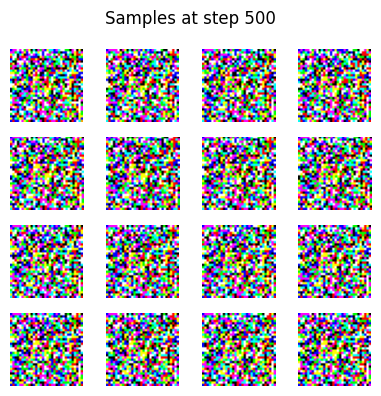

Step 1000/5000, loss_D=0.7971, loss_G=0.9403


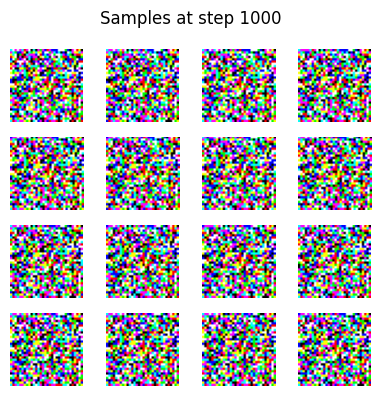

Step 1500/5000, loss_D=0.7375, loss_G=0.7344


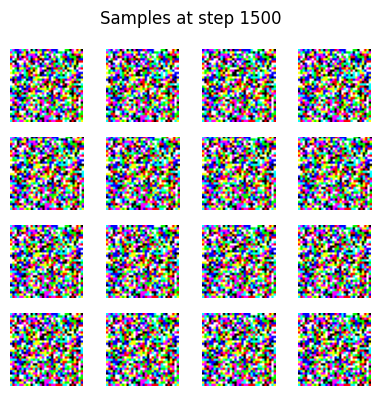

Step 2000/5000, loss_D=0.6666, loss_G=0.7599


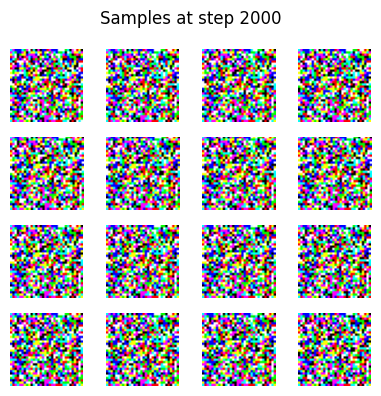

Step 2500/5000, loss_D=0.6319, loss_G=0.7921


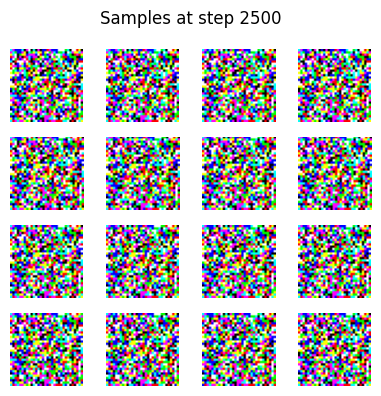

Step 3000/5000, loss_D=0.6000, loss_G=0.8237


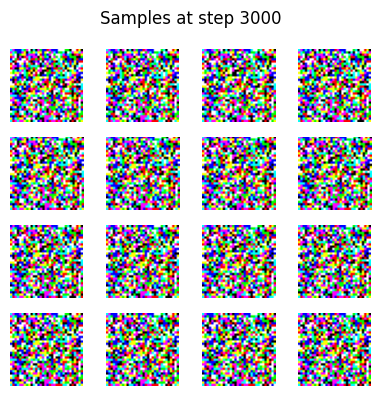

Step 3500/5000, loss_D=0.5732, loss_G=0.8580


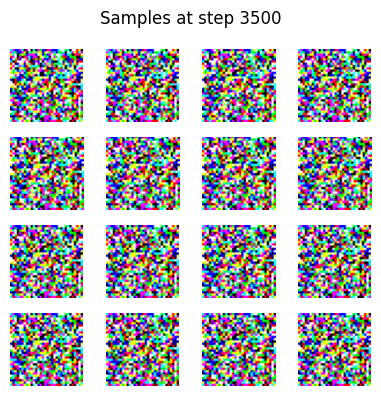

Step 4000/5000, loss_D=0.6351, loss_G=0.7805


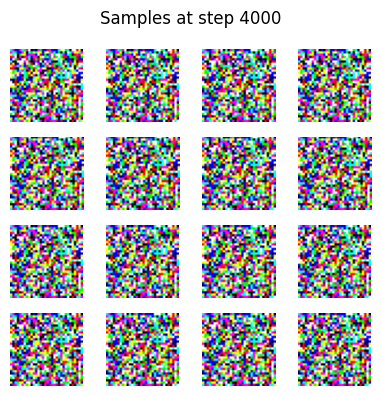

Step 4500/5000, loss_D=0.5460, loss_G=0.9284


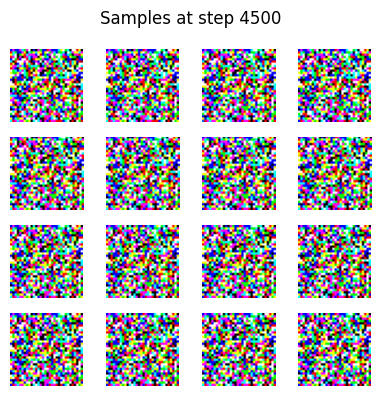

Step 5000/5000, loss_D=0.5054, loss_G=0.9613


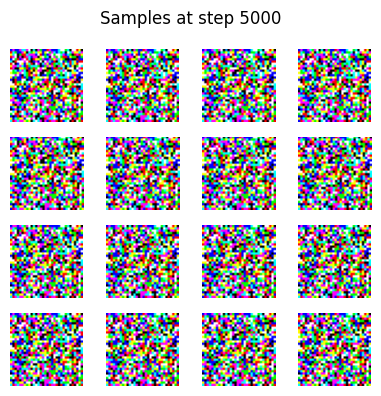

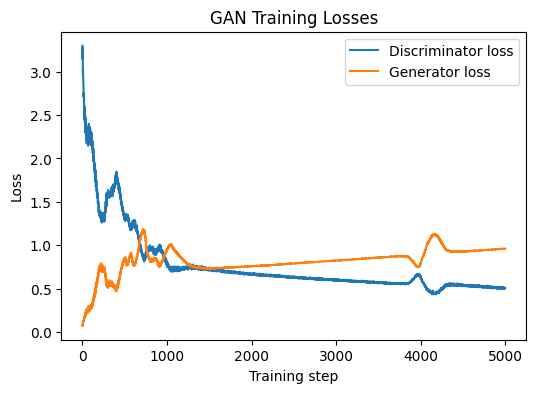

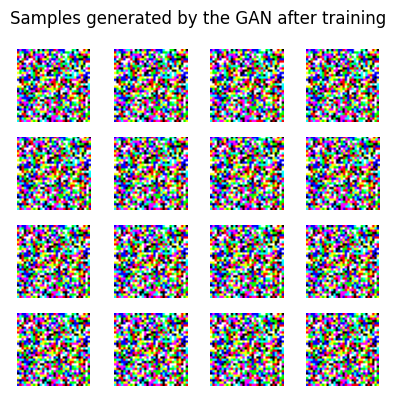

In [24]:
result=train_simple_gan(
    train,
    noise_dim=100,
    hidden_dim_g=512,
    hidden_dim_d=64,
    num_hidden_layers_g=10,
    num_hidden_layers_d=2,
    batch_size=128,
    learning_rate_d=0.0002,
    learning_rate_g=0.0005,
    num_steps=5000,
    seed=123,
    verbose_every=500,
    generate_n=16,
    plot=True,
    show_intermediate_samples=True,
    sample_interval=500,
)

### Result of training GAN on all training data from cifar-10

It appears that this results in noise, but noise that is consistent in the patterns that it creates. This seems like the GAN is training correctly because the noise pattern remains roughly the same while changing parameters of the model. The loss for the generator and discriminator do not collapse, so it appears that this is an optimal result for the data set. I will next experiment with only training a GAN on one label of data, as this will likely result in more visually significant results.

In [25]:
# Generated by GPT-5 (high reasoning) via Windsurf 9/4/25
# Prompt: Can you generate the same function above, but such that it filters and 
# only trains a subset of the labels for training? For example, I want to be able 
# to train the GAN on only data labeled as class 1

# simple_gan.py
# Updated GAN training utility compatible with CIFAR-10 Bunch objects or NumPy arrays
# Now supports training on a subset of labels via `class_filter`.
from __future__ import annotations

from typing import Any, Dict, List, Optional, Sequence, Tuple, Union

import numpy as np
import matplotlib.pyplot as plt

try:
    from sklearn.utils import Bunch  # type: ignore
except Exception:  # sklearn might not be installed in all contexts
    Bunch = object  # fallback type to allow isinstance checks to pass


ArrayLike = np.ndarray


def _as_array_data(X: ArrayLike) -> ArrayLike:
    """
    Returns a 2D NumPy array of shape (N, D). If input is images (N, H, W, C),
    it will be flattened to (N, H*W*C).
    """
    X = np.asarray(X)
    if X.ndim == 4:
        N, H, W, C = X.shape
        X = X.reshape(N, H * W * C)
    elif X.ndim != 2:
        raise ValueError(f"Expected 2D array (N, D) or 4D images (N, H, W, C), got shape {X.shape}")
    if X.dtype not in (np.float32, np.float64):
        X = X.astype(np.float32, copy=False)
    return X


def _scale_to_tanh_range(X: ArrayLike) -> ArrayLike:
    """
    Scale features to approximately match tanh output range [-1, 1].
    Heuristics:
    - If values in [0, 1], map with X*2-1.
    - Else if values look like 0..255, map with X/127.5-1.
    - Else if already in [-1, 1], leave as-is.
    - Else fallback to min-max scaling to [-1, 1].
    """
    X_min = np.min(X)
    X_max = np.max(X)

    if X_min >= -1.000001 and X_max <= 1.000001:
        return X.astype(np.float32, copy=False)

    if X_min >= -1e-6 and X_max <= 1.0 + 1e-6:
        return (X * 2.0 - 1.0).astype(np.float32, copy=False)

    if X_min >= -1e-6 and X_max > 1.0:
        # Likely 0..255 or similar
        return (X / 127.5 - 1.0).astype(np.float32, copy=False)

    # Fallback: min-max to [-1, 1]
    denom = max(X_max - X_min, 1e-8)
    X_scaled = (X - X_min) / denom
    X_scaled = X_scaled * 2.0 - 1.0
    return X_scaled.astype(np.float32, copy=False)


def _extract_X_and_labels(
    X_gan: Union[ArrayLike, Bunch],
    y: Optional[ArrayLike],
) -> Tuple[ArrayLike, Optional[ArrayLike]]:
    """
    Extract raw X (possibly images or flattened) and labels if available.
    - If X_gan is a Bunch, use `.data` for features and `.target` for labels.
    - Else treat X_gan as an array and use provided y (if any).
    Returns (X_raw, labels_or_None) where X_raw is not yet flattened or scaled.
    """
    if hasattr(X_gan, "data"):
        X_raw = np.asarray(getattr(X_gan, "data"))
        labels = np.asarray(getattr(X_gan, "target")) if hasattr(X_gan, "target") else None
        return X_raw, labels
    else:
        X_raw = np.asarray(X_gan)
        labels = np.asarray(y) if y is not None else None
        return X_raw, labels


def _apply_class_filter(
    X_raw: ArrayLike,
    labels: Optional[ArrayLike],
    class_filter: Optional[Union[int, Sequence[int]]],
) -> Tuple[ArrayLike, Optional[ArrayLike], Optional[np.ndarray]]:
    """
    If class_filter is provided, filter rows of X_raw (and labels) to keep only
    those whose label is in class_filter. Returns (X_filt, y_filt, mask).
    """
    if class_filter is None:
        return X_raw, labels, None

    if labels is None:
        raise ValueError(
            "class_filter provided but no labels found. Pass a Bunch with .target or provide y explicitly."
        )

    if isinstance(class_filter, (int, np.integer)):
        keep = {int(class_filter)}
    else:
        try:
            keep = {int(c) for c in class_filter}  # type: ignore[arg-type]
        except Exception as e:
            raise TypeError("class_filter must be an int or a sequence of ints") from e

    mask = np.isin(labels, list(keep))
    if not np.any(mask):
        raise ValueError(f"class_filter={sorted(list(keep))} matched zero samples")

    X_filt = X_raw[mask]
    y_filt = labels[mask]
    return X_filt, y_filt, mask


def train_simple_gan(
    X_gan: Union[ArrayLike, Bunch],
    *,
    y: Optional[ArrayLike] = None,
    class_filter: Optional[Union[int, Sequence[int]]] = None,
    noise_dim: int = 20,
    hidden_dim_g: int = 64,
    hidden_dim_d: int = 64,
    num_hidden_layers_g: int = 1,
    num_hidden_layers_d: int = 1,
    batch_size: int = 64,
    learning_rate_d: float = 5e-4,
    learning_rate_g: float = 5e-4,
    num_steps: int = 1500,
    seed: int = 42,
    verbose_every: int = 500,
    generate_n: int = 16,
    plot: bool = True,
    show_intermediate_samples: bool = True,
    sample_interval: int = 500,
) -> Dict[str, Any]:
    """
    Train a simple fully-connected GAN on tabular or flattened image data.

    This version is adapted to work seamlessly with CIFAR-10 loaded via a
    scikit-learn `Bunch` (see `cifar10_loader.load_cifar10`) or a raw NumPy array.

    Key features
    - Accepts (N, D) arrays or images (N, H, W, C). Images are auto-flattened.
    - Optional class subset training via `class_filter` (e.g., class_filter=1).
      Provide labels via Bunch.target or the `y` argument with arrays.
    - Real data is automatically scaled to [-1, 1] to match generator tanh output.
    - Generator: `num_hidden_layers_g` hidden layers (ReLU), final tanh to data dim.
    - Discriminator: `num_hidden_layers_d` hidden layers (ReLU), final sigmoid to 1.

    If `num_hidden_layers_* == 0`, the network reduces to a single linear layer
    to the output activation.
    """
    rng = np.random.default_rng(seed)

    def sigmoid(x):
        return 1.0 / (1.0 + np.exp(-x))

    # Prepare raw data and labels, then filter if requested
    X_raw, labels = _extract_X_and_labels(X_gan, y)
    X_raw, labels_used, mask_used = _apply_class_filter(X_raw, labels, class_filter)

    # Flatten and scale
    X = _as_array_data(X_raw)
    X = _scale_to_tanh_range(X)

    input_dim = X.shape[1]

    # Determine display shape (grayscale vs RGB) for visualization
    side_gray = int(np.sqrt(input_dim))
    is_square_gray = side_gray * side_gray == input_dim

    is_square_color = False
    side_color = 0
    if input_dim % 3 == 0:
        side_color = int(np.sqrt(input_dim // 3))
        is_square_color = (side_color * side_color * 3 == input_dim)

    # Build layer dimensions
    dims_g = [noise_dim] + [hidden_dim_g] * num_hidden_layers_g + [input_dim]
    dims_d = [input_dim] + [hidden_dim_d] * num_hidden_layers_d + [1]

    # Initialize weights
    W_g = [rng.normal(0, 0.1, size=(dims_g[i], dims_g[i + 1])) for i in range(len(dims_g) - 1)]
    b_g = [np.zeros(dims_g[i + 1]) for i in range(len(dims_g) - 1)]
    W_d = [rng.normal(0, 0.1, size=(dims_d[i], dims_d[i + 1])) for i in range(len(dims_d) - 1)]
    b_d = [np.zeros(dims_d[i + 1]) for i in range(len(dims_d) - 1)]

    # Helpers
    def forward_g(z: ArrayLike) -> Tuple[ArrayLike, List[ArrayLike], List[ArrayLike]]:
        """
        Returns:
          fake: (batch, input_dim)
          pres: list of pre-activations per layer [L0, L1, ..., Lout]
          acts: list of activations including input and hidden only: [z, h1, ..., hL] (no output)
        """
        acts: List[ArrayLike] = [z]
        pres: List[ArrayLike] = []
        a = z
        for i in range(len(W_g)):
            pre = a @ W_g[i] + b_g[i]
            pres.append(pre)
            if i < len(W_g) - 1:
                a = np.maximum(0, pre)  # ReLU hidden
                acts.append(a)
            else:
                a = np.tanh(pre)  # output
        fake = a
        return fake, pres, acts

    def forward_d(x: ArrayLike) -> Tuple[ArrayLike, ArrayLike, List[ArrayLike], List[ArrayLike]]:
        """
        Returns:
          logits: (batch, 1)
          out: sigmoid(logits)
          pres: list of pre-activations of hidden layers only
          acts: list of activations including input and hidden only: [x, h1, ..., hL]
        """
        acts: List[ArrayLike] = [x]
        pres: List[ArrayLike] = []
        a = x
        # hidden layers
        for i in range(len(W_d) - 1):
            pre = a @ W_d[i] + b_d[i]
            pres.append(pre)
            a = np.maximum(0, pre)
            acts.append(a)
        # output layer
        logits = a @ W_d[-1] + b_d[-1]
        out = sigmoid(logits)
        return logits, out, pres, acts

    # Training bookkeeping
    losses_d: List[float] = []
    losses_g: List[float] = []
    intermediate_samples: List[ArrayLike] = []

    N = X.shape[0]

    # Training loop
    for step in range(num_steps):
        # Minibatch of real samples
        replace_flag = N < batch_size
        idx = rng.choice(N, size=batch_size, replace=replace_flag)
        real_batch = X[idx]

        # Noise
        z = rng.normal(0, 1, size=(batch_size, noise_dim))

        # Forward passes
        fake_batch, g_pres, g_acts = forward_g(z)
        d_logits_real, d_out_real, d_pres_real, d_acts_real = forward_d(real_batch)
        d_logits_fake, d_out_fake, d_pres_fake, d_acts_fake = forward_d(fake_batch)

        # -------- Discriminator loss and gradients --------
        y_real = np.ones((batch_size, 1))
        y_fake = np.zeros((batch_size, 1))
        eps = 1e-8
        loss_d = -(
            np.mean(np.log(d_out_real + eps)) + np.mean(np.log(1.0 - d_out_fake + eps))
        )

        dlogits_real = (d_out_real - y_real) / batch_size  # dL/d(logits_real)
        dlogits_fake = (d_out_fake - y_fake) / batch_size  # dL/d(logits_fake)

        grad_W_d = [np.zeros_like(W) for W in W_d]
        grad_b_d = [np.zeros_like(b) for b in b_d]

        # Output layer grads
        last_hidden_real = d_acts_real[-1]  # input if no hidden layers
        last_hidden_fake = d_acts_fake[-1]
        grad_W_d[-1] = last_hidden_real.T @ dlogits_real + last_hidden_fake.T @ dlogits_fake
        grad_b_d[-1] = np.sum(dlogits_real + dlogits_fake, axis=0)

        # Backprop into hidden
        d_hidden_real = dlogits_real @ W_d[-1].T
        d_hidden_fake = dlogits_fake @ W_d[-1].T

        for l in reversed(range(len(W_d) - 1)):
            d_pre_real = d_hidden_real * (d_pres_real[l] > 0)
            d_pre_fake = d_hidden_fake * (d_pres_fake[l] > 0)
            grad_W_d[l] = d_acts_real[l].T @ d_pre_real + d_acts_fake[l].T @ d_pre_fake
            grad_b_d[l] = np.sum(d_pre_real + d_pre_fake, axis=0)
            d_hidden_real = d_pre_real @ W_d[l].T
            d_hidden_fake = d_pre_fake @ W_d[l].T

        # Update D
        for i in range(len(W_d)):
            W_d[i] -= learning_rate_d * grad_W_d[i]
            b_d[i] -= learning_rate_d * grad_b_d[i]

        # -------- Generator loss and gradients --------
        y_gen = np.ones((batch_size, 1))
        loss_g = -np.mean(np.log(d_out_fake + eps))

        # Backprop through (updated) D to its input (fake_batch)
        dlogits_fake_gen = (d_out_fake - y_gen) / batch_size  # dL/d(logits_fake) where target=1
        d_hidden = dlogits_fake_gen @ W_d[-1].T
        for l in reversed(range(len(W_d) - 1)):
            d_hidden = (d_hidden * (d_pres_fake[l] > 0)) @ W_d[l].T
        grad_input_D = d_hidden  # dL/dfake_batch

        # Backprop through G
        d_g_pre_out = grad_input_D * (1.0 - fake_batch ** 2)  # tanh' = 1 - tanh^2
        grad_W_g = [np.zeros_like(W) for W in W_g]
        grad_b_g = [np.zeros_like(b) for b in b_g]

        # Output layer grads (G)
        last_hidden_g = g_acts[-1]  # z if no hidden layers, else last hidden
        grad_W_g[-1] = last_hidden_g.T @ d_g_pre_out
        grad_b_g[-1] = np.sum(d_g_pre_out, axis=0)

        d_hidden_g = d_g_pre_out @ W_g[-1].T
        for l in reversed(range(len(W_g) - 1)):
            d_pre_g = d_hidden_g * (g_pres[l] > 0)
            grad_W_g[l] = g_acts[l].T @ d_pre_g
            grad_b_g[l] = np.sum(d_pre_g, axis=0)
            d_hidden_g = d_pre_g @ W_g[l].T

        # Update G
        for i in range(len(W_g)):
            W_g[i] -= learning_rate_g * grad_W_g[i]
            b_g[i] -= learning_rate_g * grad_b_g[i]

        # Record losses
        losses_d.append(float(loss_d))
        losses_g.append(float(loss_g))

        # Verbose logging
        if verbose_every and (step + 1) % verbose_every == 0:
            print(f"Step {step+1}/{num_steps}, loss_D={loss_d:.4f}, loss_G={loss_g:.4f}")

        # Periodic sample visualization
        can_display = is_square_gray or is_square_color
        if (
            plot
            and show_intermediate_samples
            and sample_interval
            and (step + 1) % sample_interval == 0
            and can_display
        ):
            z_sample_step = rng.normal(0, 1, size=(generate_n, noise_dim))
            fake_samples_step, _, _ = forward_g(z_sample_step)
            intermediate_samples.append(fake_samples_step)

            nrows = ncols = int(np.ceil(np.sqrt(generate_n)))
            fig, axes = plt.subplots(nrows, ncols, figsize=(ncols, nrows))
            axes = np.array(axes).reshape(nrows, ncols)
            for i, ax in enumerate(axes.flat):
                ax.axis("off")
                if i < generate_n:
                    if is_square_color:
                        img = fake_samples_step[i].reshape(side_color, side_color, 3)
                        img = (img + 1.0) / 2.0  # map back to [0,1]
                        img = np.clip(img, 0.0, 1.0)
                        ax.imshow(img)
                    elif is_square_gray:
                        img = fake_samples_step[i].reshape(side_gray, side_gray)
                        img = (img + 1.0) / 2.0
                        img = np.clip(img, 0.0, 1.0)
                        ax.imshow(img, cmap="gray")
            plt.suptitle(f"Samples at step {step+1}")
            plt.tight_layout()
            plt.show()

    # After training, generate a batch of images
    z_sample = rng.normal(0, 1, size=(generate_n, noise_dim))
    fake_samples, _, _ = forward_g(z_sample)

    if plot:
        # Loss curves
        fig, ax = plt.subplots(figsize=(6, 4))
        ax.plot(losses_d, label="Discriminator loss")
        ax.plot(losses_g, label="Generator loss")
        ax.set_xlabel("Training step")
        ax.set_ylabel("Loss")
        ax.set_title("GAN Training Losses")
        ax.legend()
        plt.show()

        # Final samples
        can_display = is_square_gray or is_square_color
        if can_display:
            nrows = ncols = int(np.ceil(np.sqrt(generate_n)))
            fig, axes = plt.subplots(nrows, ncols, figsize=(ncols, nrows))
            axes = np.array(axes).reshape(nrows, ncols)
            for i, ax in enumerate(axes.flat):
                ax.axis("off")
                if i < generate_n:
                    if is_square_color:
                        img = fake_samples[i].reshape(side_color, side_color, 3)
                        img = (img + 1.0) / 2.0
                        img = np.clip(img, 0.0, 1.0)
                        ax.imshow(img)
                    elif is_square_gray:
                        img = fake_samples[i].reshape(side_gray, side_gray)
                        img = (img + 1.0) / 2.0
                        img = np.clip(img, 0.0, 1.0)
                        ax.imshow(img, cmap="gray")
            plt.suptitle("Samples generated by the GAN after training")
            plt.tight_layout()
            plt.show()

    # Summaries
    unique_labels = np.unique(labels_used).tolist() if labels_used is not None else None

    return {
        "fake_samples": fake_samples,
        "losses_d": losses_d,
        "losses_g": losses_g,
        "intermediate_samples": intermediate_samples,
        "weights": {
            "W_g": W_g,
            "b_g": b_g,
            "W_d": W_d,
            "b_d": b_d,
        },
        "rng": rng,
        "params": {
            "noise_dim": noise_dim,
            "hidden_dim_g": hidden_dim_g,
            "hidden_dim_d": hidden_dim_d,
            "num_hidden_layers_g": num_hidden_layers_g,
            "num_hidden_layers_d": num_hidden_layers_d,
            "batch_size": batch_size,
            "learning_rate_d": learning_rate_d,
            "learning_rate_g": learning_rate_g,
            "num_steps": num_steps,
            "sample_interval": sample_interval,
            "show_intermediate_samples": show_intermediate_samples,
            "class_filter": (sorted(unique_labels) if unique_labels is not None else None),
        },
        "data_info": {
            "input_dim": input_dim,
            "n_samples_used": int(X.shape[0]),
            "display_shape": (
                (side_color, side_color, 3) if is_square_color else (side_gray, side_gray) if is_square_gray else None
            ),
            "scaled_to": "[-1, 1]",
        },
    }



Step 500/5000, loss_D=1.1155, loss_G=0.7549
Step 1000/5000, loss_D=1.1215, loss_G=0.9127


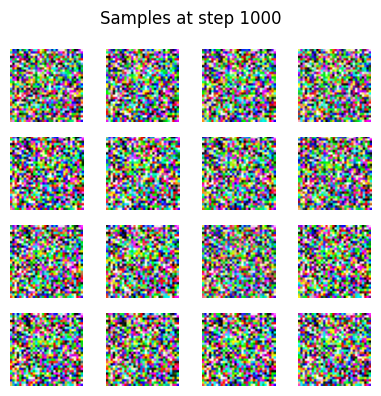

Step 1500/5000, loss_D=1.1267, loss_G=0.8141
Step 2000/5000, loss_D=0.8292, loss_G=0.9590


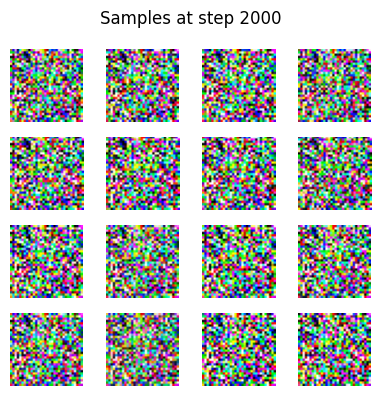

Step 2500/5000, loss_D=0.7529, loss_G=0.8005
Step 3000/5000, loss_D=0.7159, loss_G=0.7595


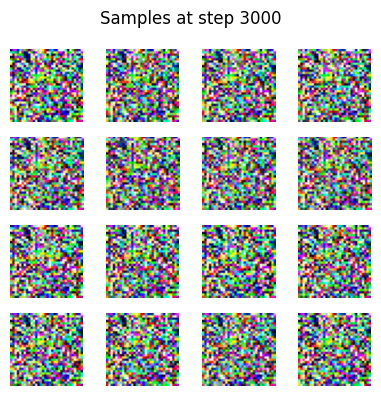

Step 3500/5000, loss_D=0.6637, loss_G=0.7783
Step 4000/5000, loss_D=0.6238, loss_G=0.8071


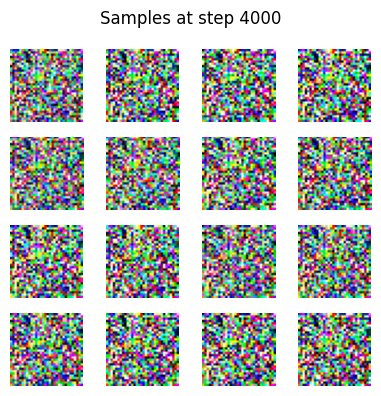

Step 4500/5000, loss_D=0.5993, loss_G=0.8278
Step 5000/5000, loss_D=0.5533, loss_G=0.9034


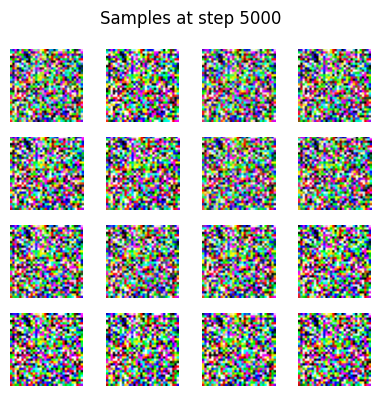

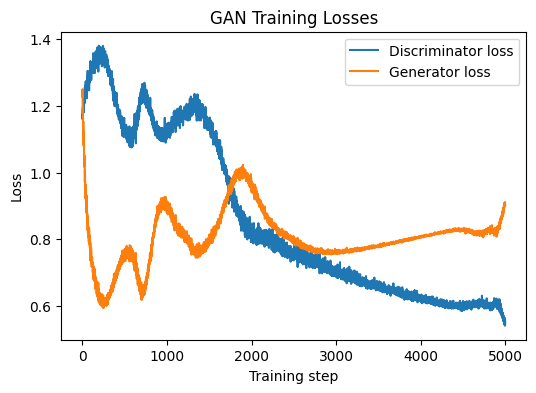

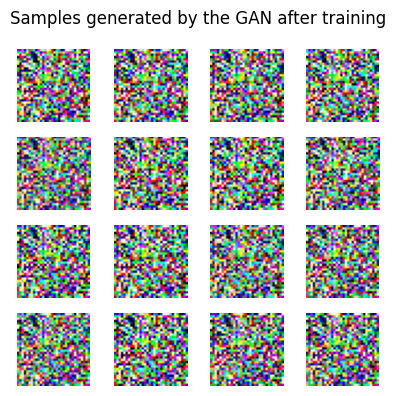

In [47]:
result=train_simple_gan(
    train,
    # 0=airplane, 1=automobile, 2=bird, 3=cat, 4=deer, 5=dog, 6=frog, 7=horse, 8=ship, 9=truck
    class_filter=8,
    noise_dim=100,
    hidden_dim_g=256,
    hidden_dim_d=32,
    num_hidden_layers_g=5,
    num_hidden_layers_d=2,
    batch_size=64,
    learning_rate_d=0.0002,
    learning_rate_g=0.0006,
    num_steps=5000,
    seed=123,
    verbose_every=500,
    generate_n=16,
    plot=True,
    show_intermediate_samples=True,
    sample_interval=1000,
)